In [1]:
import torch
class Dataset(torch.utils.data.Dataset):
    """The base class for dataset classes.
    To use it, create a new class that adds functions specific to the dataset
    you want to use. For example:
    class CatsAndDogsDataset(Dataset):
        def load_cats_and_dogs(self):
            ...
        def load_mask(self, image_id):
            ...
        def image_reference(self, image_id):
            ...
    See COCODataset and ShapesDataset as examples.
    """

    def __init__(self, class_map=None):
        self._image_ids = []
        self.image_info = []
        # Background is always the first class
        self.class_info = [{"source": "", "id": 0, "name": "BG"}]
        self.source_class_ids = {}

    def add_class(self, source, class_id, class_name):
        assert "." not in source, "Source name cannot contain a dot"
        # Does the class exist already?
        for info in self.class_info:
            if info['source'] == source and info["id"] == class_id:
                # source.class_id combination already available, skip
                return
        # Add the class
        self.class_info.append({
            "source": source,
            "id": class_id,
            "name": class_name,
        })

    def add_image(self, source, image_id, path, **kwargs):
        image_info = {
            "id": image_id,
            "source": source,
            "path": path,
        }
        image_info.update(kwargs)
        self.image_info.append(image_info)

    def image_reference(self, image_id):
        """Return a link to the image in its source Website or details about
        the image that help looking it up or debugging it.
        Override for your dataset, but pass to this function
        if you encounter images not in your dataset.
        """
        return ""

    def prepare(self, class_map=None):
        """Prepares the Dataset class for use.
        TODO: class map is not supported yet. When done, it should handle mapping
              classes from different datasets to the same class ID.
        """

        def clean_name(name):
            """Returns a shorter version of object names for cleaner display."""
            return ",".join(name.split(",")[:1])

        # Build (or rebuild) everything else from the info dicts.
        self.num_classes = len(self.class_info)
        self.class_ids = np.arange(self.num_classes)
        self.class_names = [clean_name(c["name"]) for c in self.class_info]
        self.num_images = len(self.image_info)
        self._image_ids = np.arange(self.num_images)

        self.class_from_source_map = {"{}.{}".format(info['source'], info['id']): id
                                      for info, id in zip(self.class_info, self.class_ids)}

        # Map sources to class_ids they support
        self.sources = list(set([i['source'] for i in self.class_info]))
        self.source_class_ids = {}
        # Loop over datasets
        for source in self.sources:
            self.source_class_ids[source] = []
            # Find classes that belong to this dataset
            for i, info in enumerate(self.class_info):
                # Include BG class in all datasets
                if i == 0 or source == info['source']:
                    self.source_class_ids[source].append(i)

    def map_source_class_id(self, source_class_id):
        """Takes a source class ID and returns the int class ID assigned to it.
        For example:
        dataset.map_source_class_id("coco.12") -> 23
        """
        return self.class_from_source_map[source_class_id]

    def get_source_class_id(self, class_id, source):
        """Map an internal class ID to the corresponding class ID in the source dataset."""
        info = self.class_info[class_id]
        assert info['source'] == source
        return info['id']

    def append_data(self, class_info, image_info):
        self.external_to_class_id = {}
        for i, c in enumerate(self.class_info):
            for ds, id in c["map"]:
                self.external_to_class_id[ds + str(id)] = i

        # Map external image IDs to internal ones.
        self.external_to_image_id = {}
        for i, info in enumerate(self.image_info):
            self.external_to_image_id[info["ds"] + str(info["id"])] = i

    @property
    def image_ids(self):
        return self._image_ids

    def source_image_link(self, image_id):
        """Returns the path or URL to the image.
        Override this to return a URL to the image if it's availble online for easy
        debugging.
        """
        return self.image_info[image_id]["path"]

In [99]:
import os
import numpy as np
import torch
from augment_preprocess import fix_crop_transform, random_crop_transform, relabel_multi_mask
from augment_preprocess import random_shift_scale_rotate_transform, clean_masks
from config import Config, load_img
import h5py
import utils
from torchvision import transforms
import matplotlib.pyplot as plt
normilize  =transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225],inplace = True)

class NucleiDataset(Dataset):

    def load_shapes(self, id_list, train_path,mode):
        """initialize the class with dataset info.
        """
        self.transform = transforms.Compose([
                            transforms.ToTensor(),
        normilize])
                           
        self.config = Config()
        if mode == 'train':
            self.augment = True
        else:
            self.augment = False
        # Add classes
        self.add_class('images', 1, "nucleus")
        self.train_path = train_path
        self.imgs = id_list
        # Add images
        for i, id_ in enumerate(id_list):
            self.add_image('images', image_id=i, path=None,
                           img_name=id_)
            
            
    def load_image(self, image_id, color):
        """Load image from directory
        """

        info = self.image_info[image_id]
        path = self.train_path + info['img_name'] + \
            '/images/' + info['img_name'] + '.png'

        img = load_img(path, color=color)

        return img

    def image_reference(self, image_id):
        """Return the images data of the image."""
        info = self.image_info[image_id]
        if info["source"] == 'images':
            return info['images']
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for images of the given image ID.
        """

        info = self.image_info[image_id]

        path = self.train_path + info['img_name'] + \
            '/masks/' + info['img_name'] + '.h5'
        if os.path.exists(path):
            # For faster data loading run augment_preprocess.py file first
            # That should save masks in a single h5 file
            with h5py.File(path, "r") as hf:
                mask = hf["arr"][()]
        else:
            path = self.train_path + info['img_name']
            mask = []
            for mask_file in next(os.walk(path + '/masks/'))[2]:
                if 'png' in mask_file:
                    mask_ = cv2.imread(path + '/masks/' + mask_file, 0)
                    mask_ = np.where(mask_ > 128, 1, 0)
                    # Fill holes in the mask
                    mask_ = binary_fill_holes(mask_).astype(np.int32)
                    # Add mask only if its area is larger than one pixel
                    if np.sum(mask_) >= 1:
                        mask.append(np.squeeze(mask_))

            mask = np.stack(mask, axis=-1)
            mask = mask.astype(np.uint8)

        # Class ids: all ones since all are foreground objects
        class_ids = np.ones(mask.shape[2])

        return mask.astype(np.uint8), class_ids.astype(np.int8)

    def __getitem__(self, image_id):
        # load images ad masks
        # Load image and mask
        image = self.load_image(image_id, self.config.IMAGE_COLOR)
        masks, class_ids = self.load_mask(image_id)
        temp_image, temp_mask = random_crop_transform(image, masks, 512, 512)
        keep_ind = np.where(np.sum(temp_mask, axis=(0, 1)) > 0)[0]
        if len(keep_ind) > 0:
            image = temp_image.copy()
            masks = temp_mask[:,:,keep_ind]

        

        # Random scaling
        if self.augment and self.config.SCALE and np.random.rand() < 0.9:
            H, W = masks.shape[:2]
             #multi_mask = np.sum(mask*np.arange(1, mask.shape[-1]+1), axis=-1)
            temp_image, temp_mask = random_shift_scale_rotate_transform(image.copy(), masks.copy(),
                                                                         shift_limit=[-0.1,0.1], scale_limit=[1/1.5, 1.5],
                                                                         rotate_limit=[-15, 15])
            temp_mask = temp_mask if len(temp_mask.shape) ==3 else np.expand_dims(temp_mask,axis = 2)
             #temp_mask = np.repeat(multi_mask[:, :, np.newaxis], multi_mask.max(), axis=-1)
             #temp_mask = np.equal(temp_mask, np.ones_like(temp_mask)*np.arange(1, multi_mask.max()+1)).astype(np.uint8)

            keep_ind = np.where(np.sum(temp_mask, axis=(0, 1)) > 0)[0]
            if len(keep_ind) > 0:
                image = temp_image
                masks = temp_mask[:,:,keep_ind]

         #print(masks.shape)
        # Random cropping
        if (masks.shape[2] > 80) or (self.augment and self.config.CROP and np.random.rand() < 0.5):

            height = self.config.CROP_SHAPE[1]
            width = self.config.CROP_SHAPE[0]

            temp_image, temp_mask = random_crop_transform(image, masks, height, width)
            keep_ind = np.where(np.sum(temp_mask, axis=(0, 1)) > 0)[0]
            if len(keep_ind) > 0:
                image = temp_image.copy()
                masks = temp_mask[:,:,keep_ind]

        shape = image.shape
        image, window, scale, padding = utils.resize_image(
            image,
            min_dim=self.config.IMAGE_MIN_DIM,
            max_dim=self.config.IMAGE_MAX_DIM,
            padding=self.config.IMAGE_PADDING)
        masks = utils.resize_mask(masks, scale, padding)
        
    
        
        # Random horizontal and vertical flips.
        if self.augment:

            # horizontal
            if np.random.rand() < 0.5:
                image = np.fliplr(image)
                masks = np.fliplr(masks)
            # Vertical
            if np.random.rand() < 0.5:
                image = np.flipud(image)
                masks = np.flipud(masks)

            # Random 90 degree rotation
            if np.random.rand() < 0.5:
                angle = np.random.choice([1, -1])
                image = np.rot90(image, k=angle, axes=(0, 1))
                masks = np.rot90(masks, k=angle, axes=(0, 1))

            # # Random Gaussian blur
            # if random.randint(0, 1):
            #     sigma = np.random.uniform(1.5,2.5)
            #     image = cv2.GaussianBlur(image, (33, 33), sigma)
        
        
    
        keep_ind = np.where(np.sum(masks, axis=(0, 1)) > 0)[0]
        if len(keep_ind) > 0:
            masks = masks[:,:,keep_ind]
         #image =  np.swapaxes(np.swapaxes(image,1,2),0,1)
        
        masks = masks.transpose((2, 0, 1))
         # get bounding box coordinates for each mask
        num_objs = masks.shape[0]
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
            
        print(image_id,masks.shape,image.shape)
        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image  = self.transform((image/image.max()).astype(np.float32))
        image_id = torch.tensor([image_id])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
       
        return image, target

    def __len__(self):
        return len(self.imgs)

In [100]:
def train_validation_split(train_path,classes_csv , seed=10, test_size=0.1):

    """
    Split the dataset into train and validation sets.
    External data and mosaics are directly appended to training set.
    """
    from sklearn.model_selection import train_test_split
    import pandas as pd 
    
    image_ids = list(
        filter(lambda x: ('mosaic' not in x) and ('TCGA' not in x), os.listdir(train_path)))
    mosaic_ids = list(filter(lambda x: 'mosaic' in x, os.listdir(train_path)))
    external_ids = list(filter(lambda x: 'TCGA' in x, os.listdir(train_path)))

    # Load and preprocess the dataset with train image modalities
    df = pd.read_csv(classes_csv)
    df['labels'] = df['foreground'].astype(str) + df['background']
    df['filename'] = df['filename'].apply(lambda x: x[:-4])
    df = df.set_index('filename')
    df = df.loc[image_ids]
    df = df.loc[df.background == 'black']
    # Split training set based on provided image modalities
    # This ensures that model validates on all image modalities.
    train_list, val_list = train_test_split(df.index, test_size=test_size,
                                            random_state=seed, stratify=df['labels'])

    # Add external data and mos ids to training list
    train_list = list(train_list)
    val_list = list(val_list)

    return train_list, val_list

In [101]:
import os.path as op
from config import DATASET_PATH
train_path = op.join(DATASET_PATH,'stage1_train/')
classes_csv = op.join(DATASET_PATH,'classes.csv')

# Split the training set into training and validation
train_list, val_list = train_validation_split(
    train_path,classes_csv , seed=11, test_size=0.1)

# initialize training dataset
dataset_train = NucleiDataset()
dataset_train.load_shapes(train_list, train_path,'train')
dataset_train.prepare()

# initialize validation dataset
dataset_val = NucleiDataset()
dataset_val.load_shapes(val_list, train_path,'val')
dataset_val.prepare()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3 (21, 1024, 1024) (1024, 1024, 3)


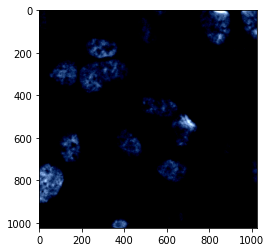

In [102]:
image,target =dataset_train.__getitem__(3)
plt.imshow(image.numpy().transpose((1, 2, 0)))

In [107]:
image.mean((1,2))

tensor([-1.3368, -1.2367, -1.0119])

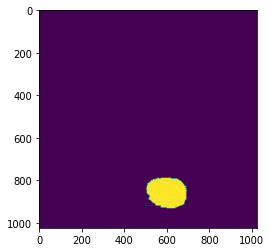

In [64]:
plt.imshow(target['masks'][0])

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import torch

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [12]:
from engine import train_one_epoch
import utils
from config import DATASET_PATH
import os.path as op

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2



train_path = op.join(DATASET_PATH,'stage1_train/')
classes_csv = op.join(DATASET_PATH,'classes.csv')

# Split the training set into training and validation
train_list, val_list = train_validation_split(
    train_path,classes_csv , seed=11, test_size=0.1)

# initialize training dataset
dataset_train = NucleiDataset()
dataset_train.load_shapes(train_list, train_path,'train')
dataset_train.prepare()

# initialize validation dataset
dataset_val = NucleiDataset()
dataset_val.load_shapes(val_list, train_path,'val')
dataset_val.prepare()


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

0 (20, 1024, 1024) (1024, 1024, 3)
Epoch: [0]  [  0/491]  eta: 0:07:34  lr: 0.000002  loss: 7.0142 (7.0142)  loss_classifier: 0.6326 (0.6326)  loss_box_reg: 0.5451 (0.5451)  loss_mask: 4.9485 (4.9485)  loss_objectness: 0.8089 (0.8089)  loss_rpn_box_reg: 0.0791 (0.0791)  time: 0.9262  data: 0.5621  max mem: 1920
1 (19, 1024, 1024) (1024, 1024, 3)
2 (89, 1024, 1024) (1024, 1024, 3)
3 (20, 1024, 1024) (1024, 1024, 3)
4 (9, 1024, 1024) (1024, 1024, 3)
5 (14, 1024, 1024) (1024, 1024, 3)
6 (6, 1024, 1024) (1024, 1024, 3)
7 (21, 1024, 1024) (1024, 1024, 3)
8 (9, 1024, 1024) (1024, 1024, 3)
9 (48, 1024, 1024) (1024, 1024, 3)
10 (19, 1024, 1024) (1024, 1024, 3)
Epoch: [0]  [ 10/491]  eta: 0:08:35  lr: 0.000012  loss: 6.4504 (6.8507)  loss_classifier: 0.5815 (0.5846)  loss_box_reg: 0.5451 (0.5264)  loss_mask: 3.9289 (3.9325)  loss_objectness: 1.2320 (1.6392)  loss_rpn_box_reg: 0.1129 (0.1680)  time: 1.0714  data: 0.7534  max mem: 2316
11 (15, 1024, 1024) (1024, 1024, 3)
12 (28, 1024, 1024) (1024

128 (20, 1024, 1024) (1024, 1024, 3)
129 (61, 1024, 1024) (1024, 1024, 3)
130 (5, 1024, 1024) (1024, 1024, 3)
Epoch: [0]  [130/491]  eta: 0:16:52  lr: 0.000134  loss: 1.2274 (2.4653)  loss_classifier: 0.2884 (0.4086)  loss_box_reg: 0.4225 (0.4474)  loss_mask: 0.2497 (0.8121)  loss_objectness: 0.1086 (0.5648)  loss_rpn_box_reg: 0.1501 (0.2325)  time: 2.9087  data: 2.5872  max mem: 2652
131 (65, 1024, 1024) (1024, 1024, 3)
132 (28, 1024, 1024) (1024, 1024, 3)
133 (40, 1024, 1024) (1024, 1024, 3)
134 (10, 1024, 1024) (1024, 1024, 3)
135 (76, 1024, 1024) (1024, 1024, 3)
136 (1, 1024, 1024) (1024, 1024, 3)
137 (9, 1024, 1024) (1024, 1024, 3)
138 (48, 1024, 1024) (1024, 1024, 3)
139 (17, 1024, 1024) (1024, 1024, 3)
140 (9, 1024, 1024) (1024, 1024, 3)
Epoch: [0]  [140/491]  eta: 0:15:45  lr: 0.000144  loss: 1.2206 (2.3816)  loss_classifier: 0.2546 (0.3969)  loss_box_reg: 0.3623 (0.4376)  loss_mask: 0.2485 (0.7814)  loss_objectness: 0.0605 (0.5382)  loss_rpn_box_reg: 0.1320 (0.2275)  time: 1.5

253 (38, 1024, 1024) (1024, 1024, 3)
254 (46, 1024, 1024) (1024, 1024, 3)
255 (21, 1024, 1024) (1024, 1024, 3)
256 (59, 1024, 1024) (1024, 1024, 3)
257 (19, 1024, 1024) (1024, 1024, 3)
258 (23, 1024, 1024) (1024, 1024, 3)
259 (6, 1024, 1024) (1024, 1024, 3)
260 (35, 1024, 1024) (1024, 1024, 3)
Epoch: [0]  [260/491]  eta: 0:10:38  lr: 0.000267  loss: 1.1680 (1.7981)  loss_classifier: 0.2137 (0.3283)  loss_box_reg: 0.1779 (0.3482)  loss_mask: 0.2009 (0.5466)  loss_objectness: 0.1006 (0.3567)  loss_rpn_box_reg: 0.1472 (0.2182)  time: 2.4490  data: 2.1222  max mem: 3043
261 (15, 1024, 1024) (1024, 1024, 3)
262 (15, 1024, 1024) (1024, 1024, 3)
263 (92, 1024, 1024) (1024, 1024, 3)
264 (21, 1024, 1024) (1024, 1024, 3)
265 (1, 1024, 1024) (1024, 1024, 3)
266 (34, 1024, 1024) (1024, 1024, 3)
267 (22, 1024, 1024) (1024, 1024, 3)
268 (32, 1024, 1024) (1024, 1024, 3)
269 (28, 1024, 1024) (1024, 1024, 3)
270 (58, 1024, 1024) (1024, 1024, 3)
Epoch: [0]  [270/491]  eta: 0:10:17  lr: 0.000277  loss: 1

KeyboardInterrupt: 